In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import arviz as az
from corner import corner

import pymc as pm
from pymc.model.transform.optimization import freeze_dims_and_data

import preliz as pz
import nutpie as ntp

In [3]:
gcn_file = "../GCN Files/sims_2024/nk_complete_more_shocks.gcn"
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	31 equations
	31 variables
		The following variables were eliminated at user request:
			D_t, K_d_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	9 stochastic shocks
		 0 / 9 has a defined prior. 
	26 parameters
		 24 / 26 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
ge.check_steady_state(mod, pi_bar=1.001)

Steady state successfully found!


In [6]:
pi_bar_values = np.linspace(-0.005, 0.01, 100)
ss_pi_bar = pd.DataFrame(
    [mod.steady_state(pi_bar=1 + pi_bar, sigma=1.0) for pi_bar in pi_bar_values],
    index=pi_bar_values,
)

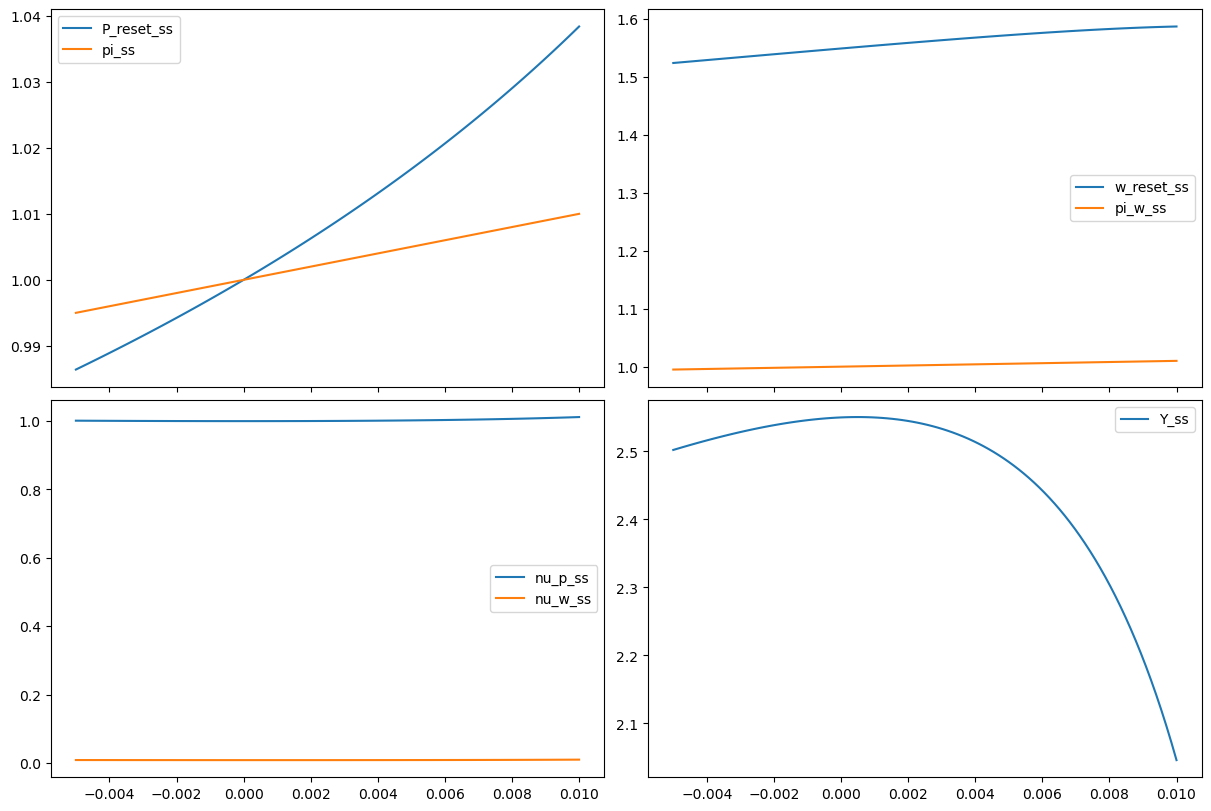

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout="constrained")
variables = [
    ["P_reset_ss", "pi_ss"],
    ["w_reset_ss", "pi_w_ss"],
    ["nu_p_ss", "nu_w_ss"],
    ["Y_ss"],
]

for var, axis in zip(variables, fig.axes):
    ss_pi_bar[var].plot(ax=axis)

plt.show()

In [8]:
irf_scenarios = {
    "both_sticky": {"phi_p": 0.75, "phi_w": 0.75},
    "prices_sticky": {"phi_p": 0.75, "phi_w": 0.0},
    "wages_sticky": {"phi_p": 0.0, "phi_w": 0.75},
}

shock_size = {
    "epsilon_i": 0.0025,
    "epsilon_G": 0.01,
    "epsilon_A": 0.01,
    "epsilon_pi_obj": 0.001,
    "epsilon_beta": 0.01,
    "epsilon_theta": 1,
    "epsilon_I": 0.01,
}

In [9]:
irfs = {
    name: ge.impulse_response_function(
        mod,
        **scenario_params,
        shock_size=shock_size,
        simulation_length=20,
        not_loglin_variables=["i", "pi", "pi_obj"],
        verbose=False,
    ).isel(time=slice(1, None))
    for name, scenario_params in irf_scenarios.items()
}

In [10]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

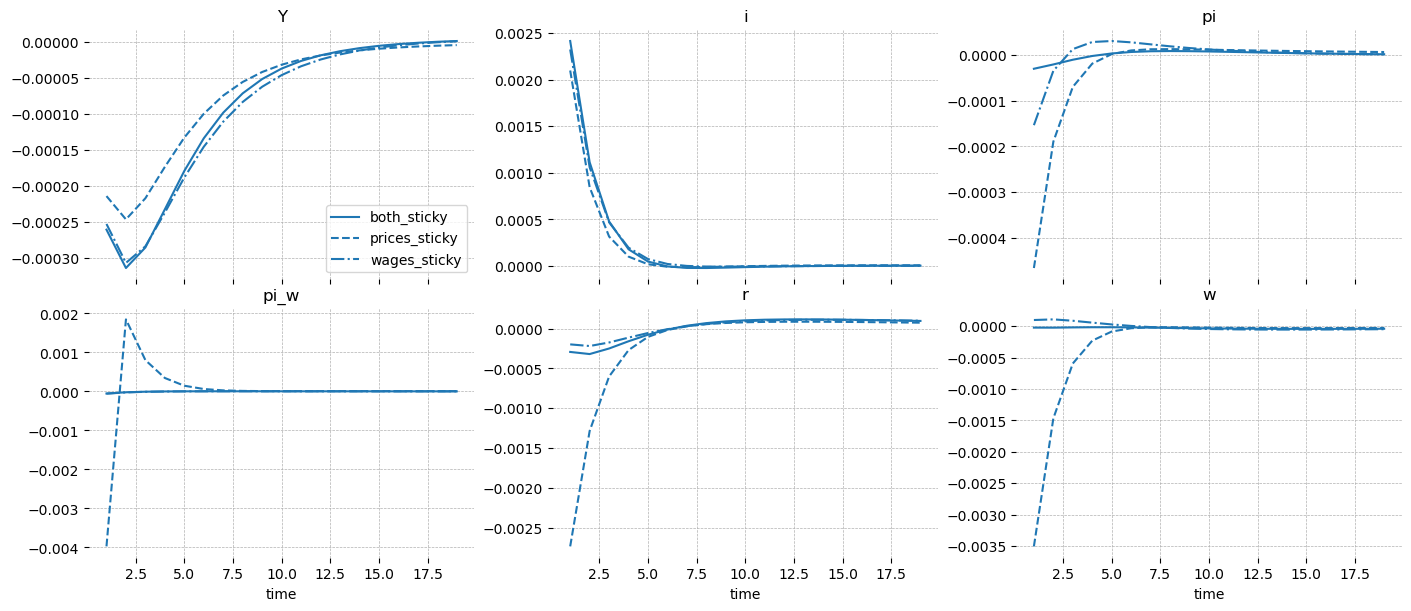

In [11]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

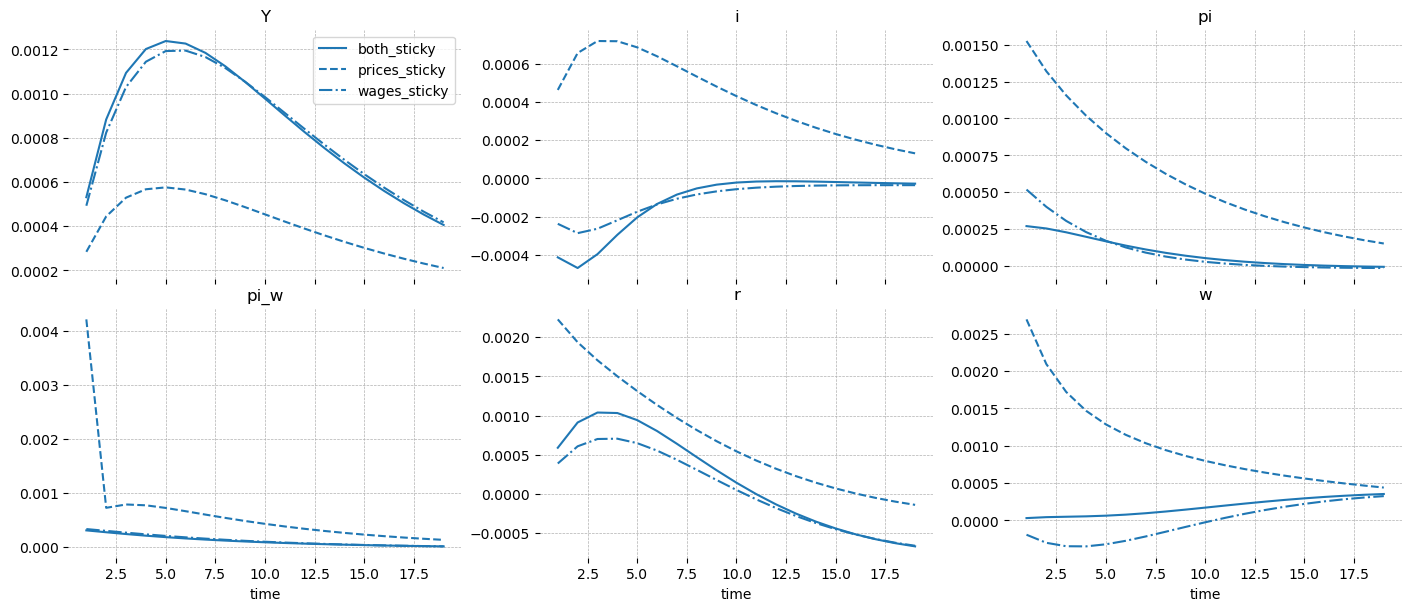

In [12]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w", "r", "w"],
    shocks_to_plot=["epsilon_pi_obj"],
    n_cols=3,
    figsize=(14, 6),
);

In [13]:
irf_scenarios = {f"{phi_H=}": {"phi_H": phi_H} for phi_H in [0.01, 0.25, 0.75, 0.99]}
irfs = {
    name: ge.impulse_response_function(
        mod,
        **scenario_params,
        shock_size=shock_size,
        simulation_length=20,
        not_loglin_variables=["i", "pi", "pi_obj"],
        verbose=False,
    ).isel(time=slice(1, None))
    for name, scenario_params in irf_scenarios.items()
}

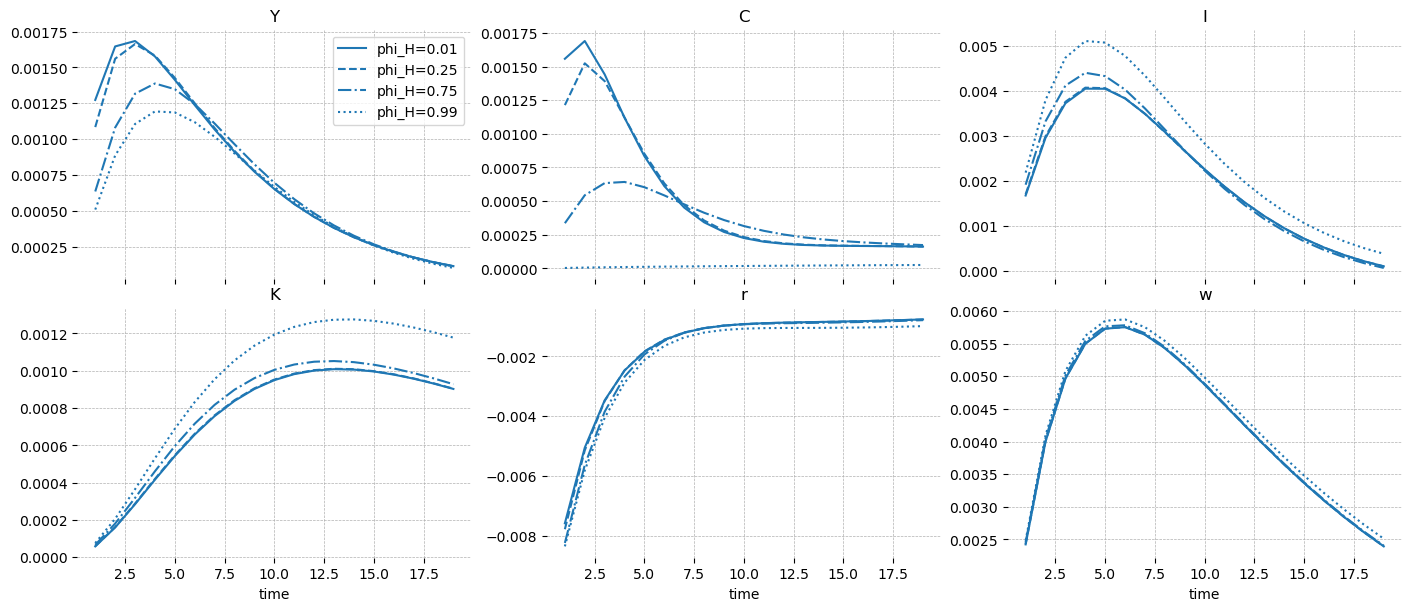

In [14]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "C", "I", "K", "r", "w"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

In [15]:
ss_mod = ge.statespace_from_gcn(gcn_file, not_loglin_variables=["i", "pi", "pi_obj"])

Model Building Complete.
Found:
	31 equations
	31 variables
		The following variables were eliminated at user request:
			D_t, K_d_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	9 stochastic shocks
		 0 / 9 has a defined prior. 
	26 parameters
		 24 / 26 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


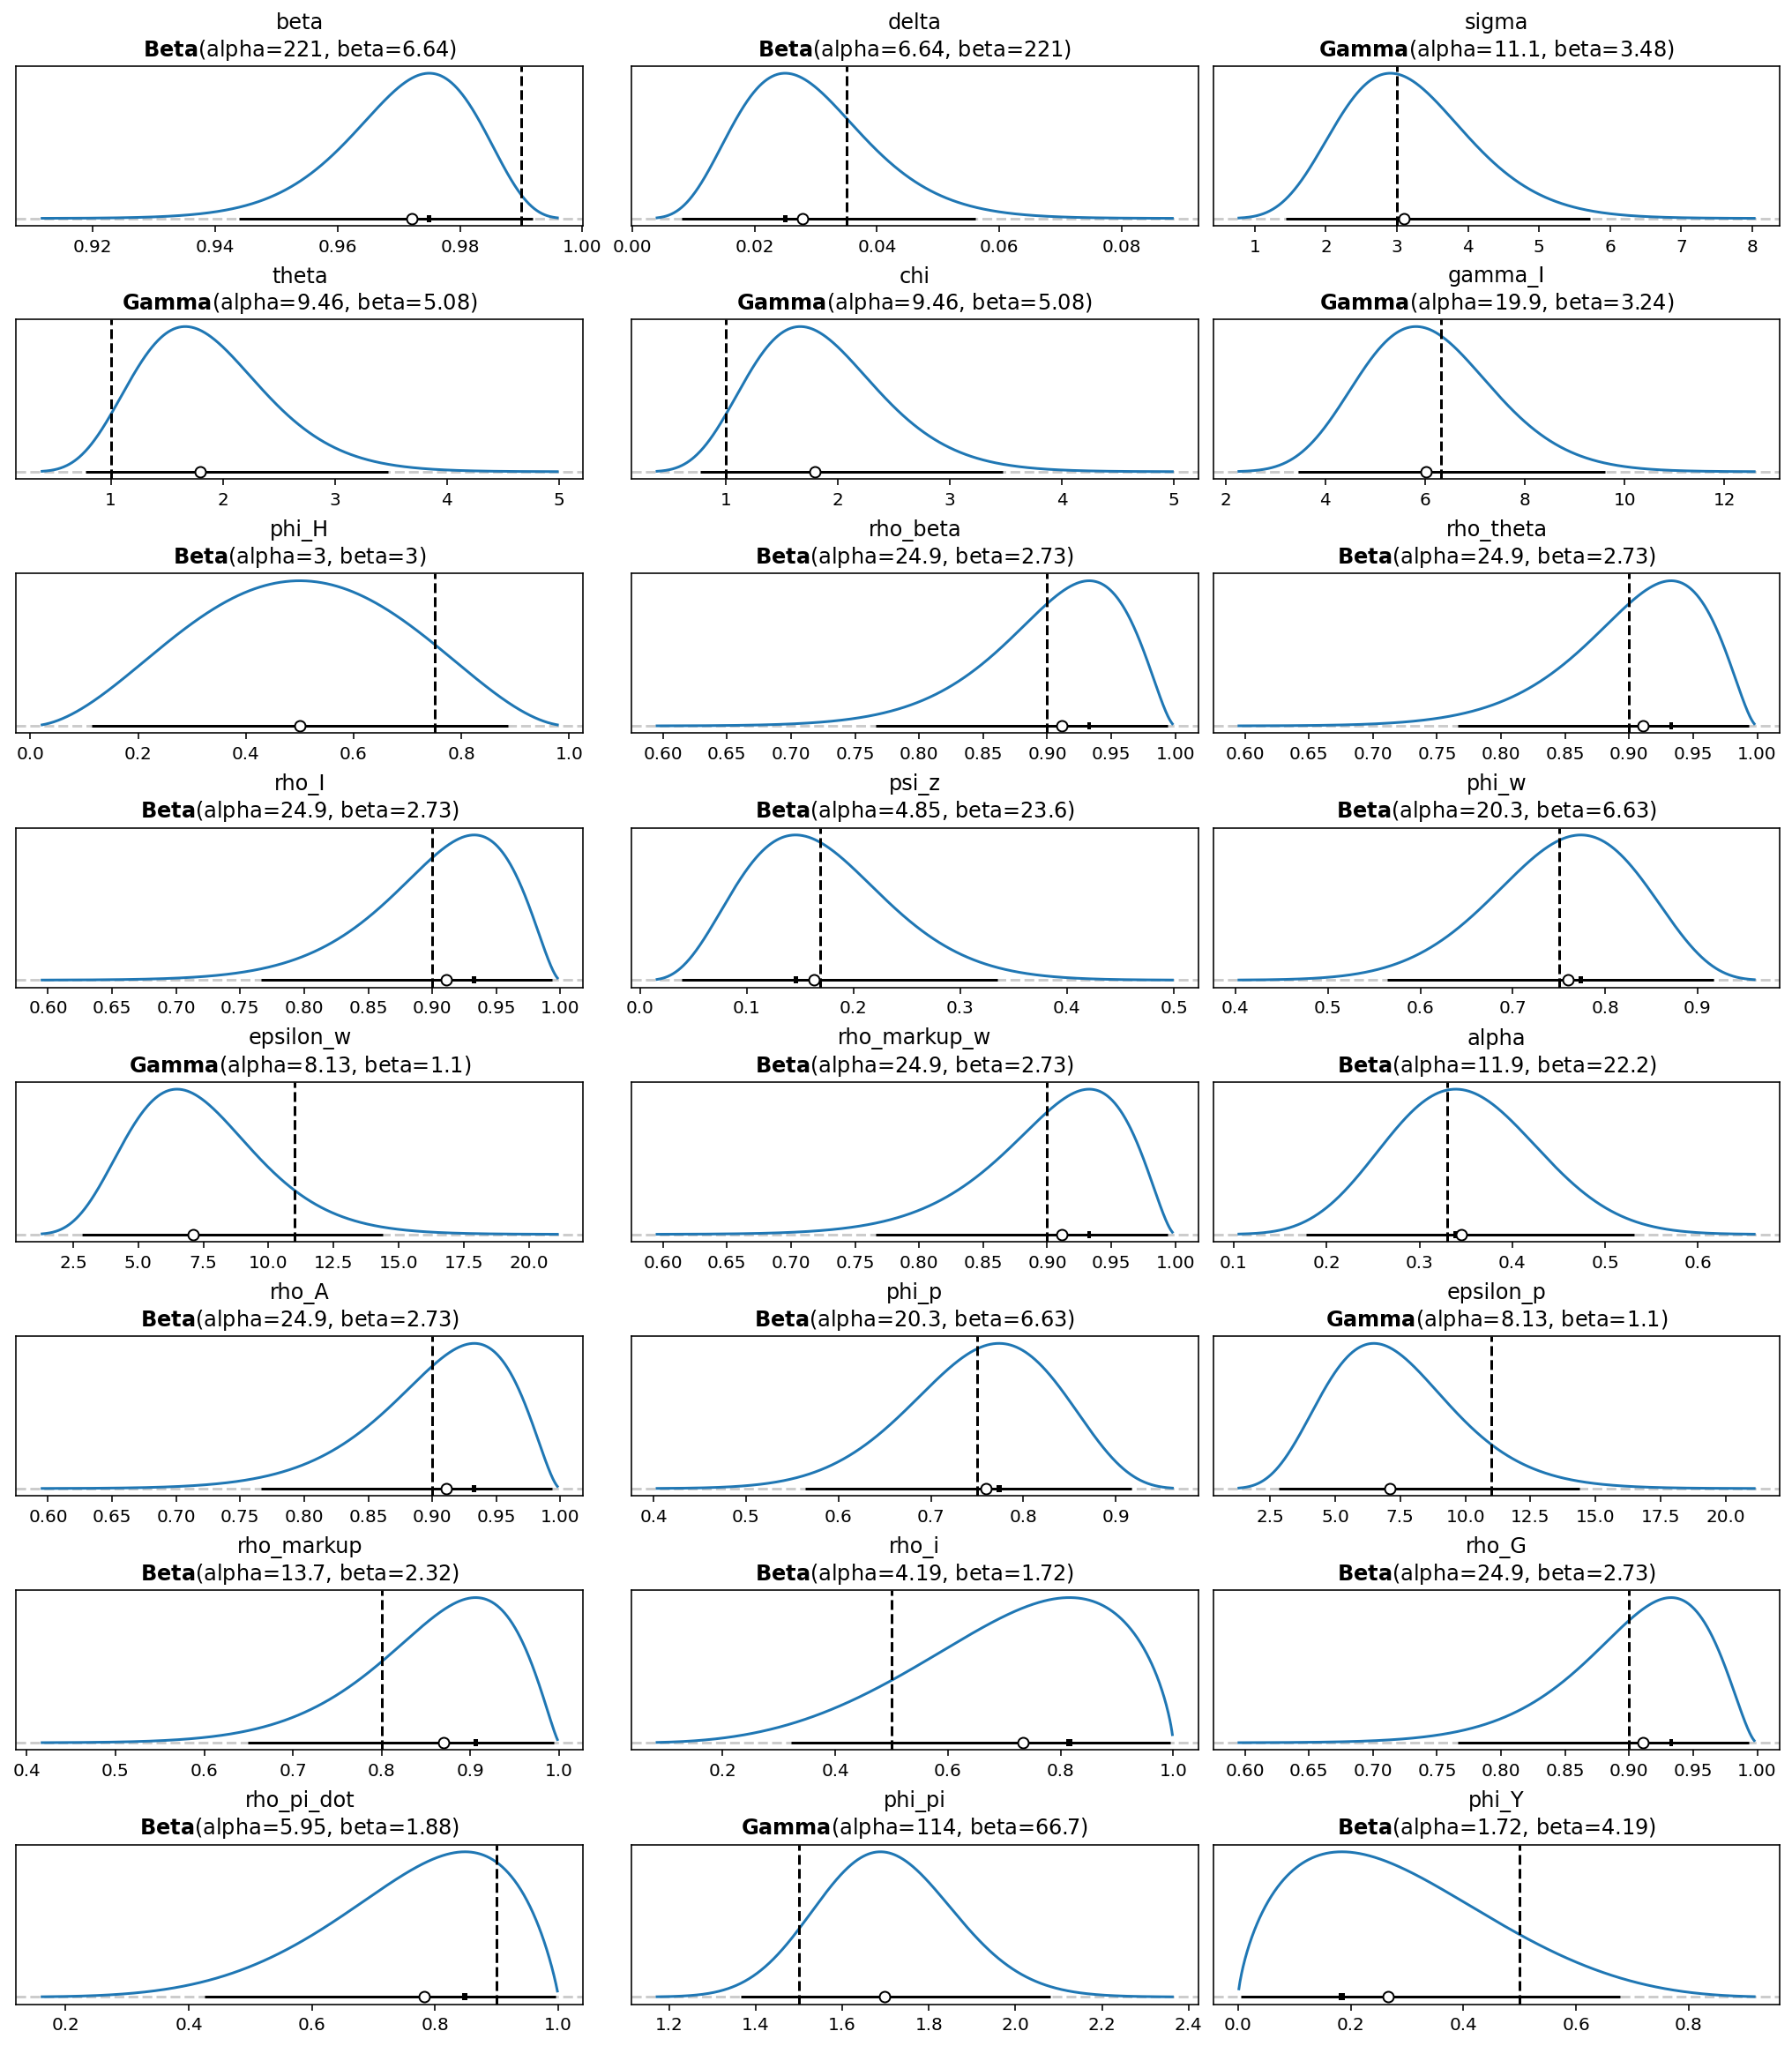

In [16]:
gp.plot_priors(ss_mod, n_cols=3);

In [17]:
ss_mod.configure(
    observed_states=["Y", "C", "I", "K", "N", "pi", "pi_obj", "i", "w", "r"],
    measurement_error=[
        "Y",
        "C",
        "I",
        "K",
        "N",
        "pi",
        "pi_obj",
        "i",
        "w",
        "r",
    ],
    constant_params=["pi_bar", "psi"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	alpha -- shape: (), constraints: None, dims: None
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	delta -- shape: (), constraints: None, dims: None
	epsilon_p -- shape: (), constraints: None, dims: None
	epsilon_w -- shape: (), constraints: None, dims: None
	gamma_I -- shape: (), constraints: None, dims: None
	phi_H -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_p -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	phi_w -- shape: (), constraints: None, dims: None
	psi_z -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_G -- shape: (), constraints: None, dims: None
	rho_I -- shape: (), constraints: None, dims: None
	rho_beta -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dim

In [18]:
n_shocks = ss_mod.k_posdef

A_params = pz.maxent(pz.Gamma(), lower=0.1, upper=0.5, plot=False).params_dict
other_params = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, plot=False).params_dict

sd_dist = pm.Gamma.dist(
    alpha=[A_params["alpha"]] + [other_params["alpha"]] * (n_shocks - 1),
    beta=[A_params["beta"]] + [other_params["beta"]] * (n_shocks - 1),
)

In [19]:
import pytensor.tensor as pt

all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    #     cov_diag = pm.Gamma('cov_diag',
    #                         alpha=[A_params['alpha']] + [other_params['alpha']] * (n_shocks - 1),
    #                         beta=[A_params['beta']] + [other_params['beta']] * (n_shocks - 1),
    #                         dims=['shock'])
    #     state_cov = pm.Deterministic('state_cov', pt.diag(cov_diag), dims=['shock', 'shock_aux'])
    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=ss_mod.k_posdef, eta=4, sd_dist=sd_dist
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

In [20]:
date_range = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
true_params, data, prior_idata = ge.data_from_prior(
    ss_mod, pm_mod, index=date_range, n_samples=500, pct_missing=0
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [alpha, beta, chi, delta, epsilon_p, epsilon_w, error_sigma_C, error_sigma_I, error_sigma_K, error_sigma_N, error_sigma_Y, error_sigma_i, error_sigma_pi, error_sigma_pi_obj, error_sigma_r, error_sigma_w, gamma_I, obs, phi_H, phi_Y, phi_p, phi_pi, phi_w, psi_z, rho_A, rho_G, rho_I, rho_beta, rho_i, rho_markup, rho_markup_w, rho_pi_dot, rho_theta, sigma, state_chol, theta]
Sampling: [prior_combined]


Output()

In [21]:
idx = true_params.param_idx
latent_data = (
    prior_idata.conditional_prior.prior_latent.sel(chain=0, draw=idx)
    .to_dataframe()
    .prior_latent.unstack("state")
)

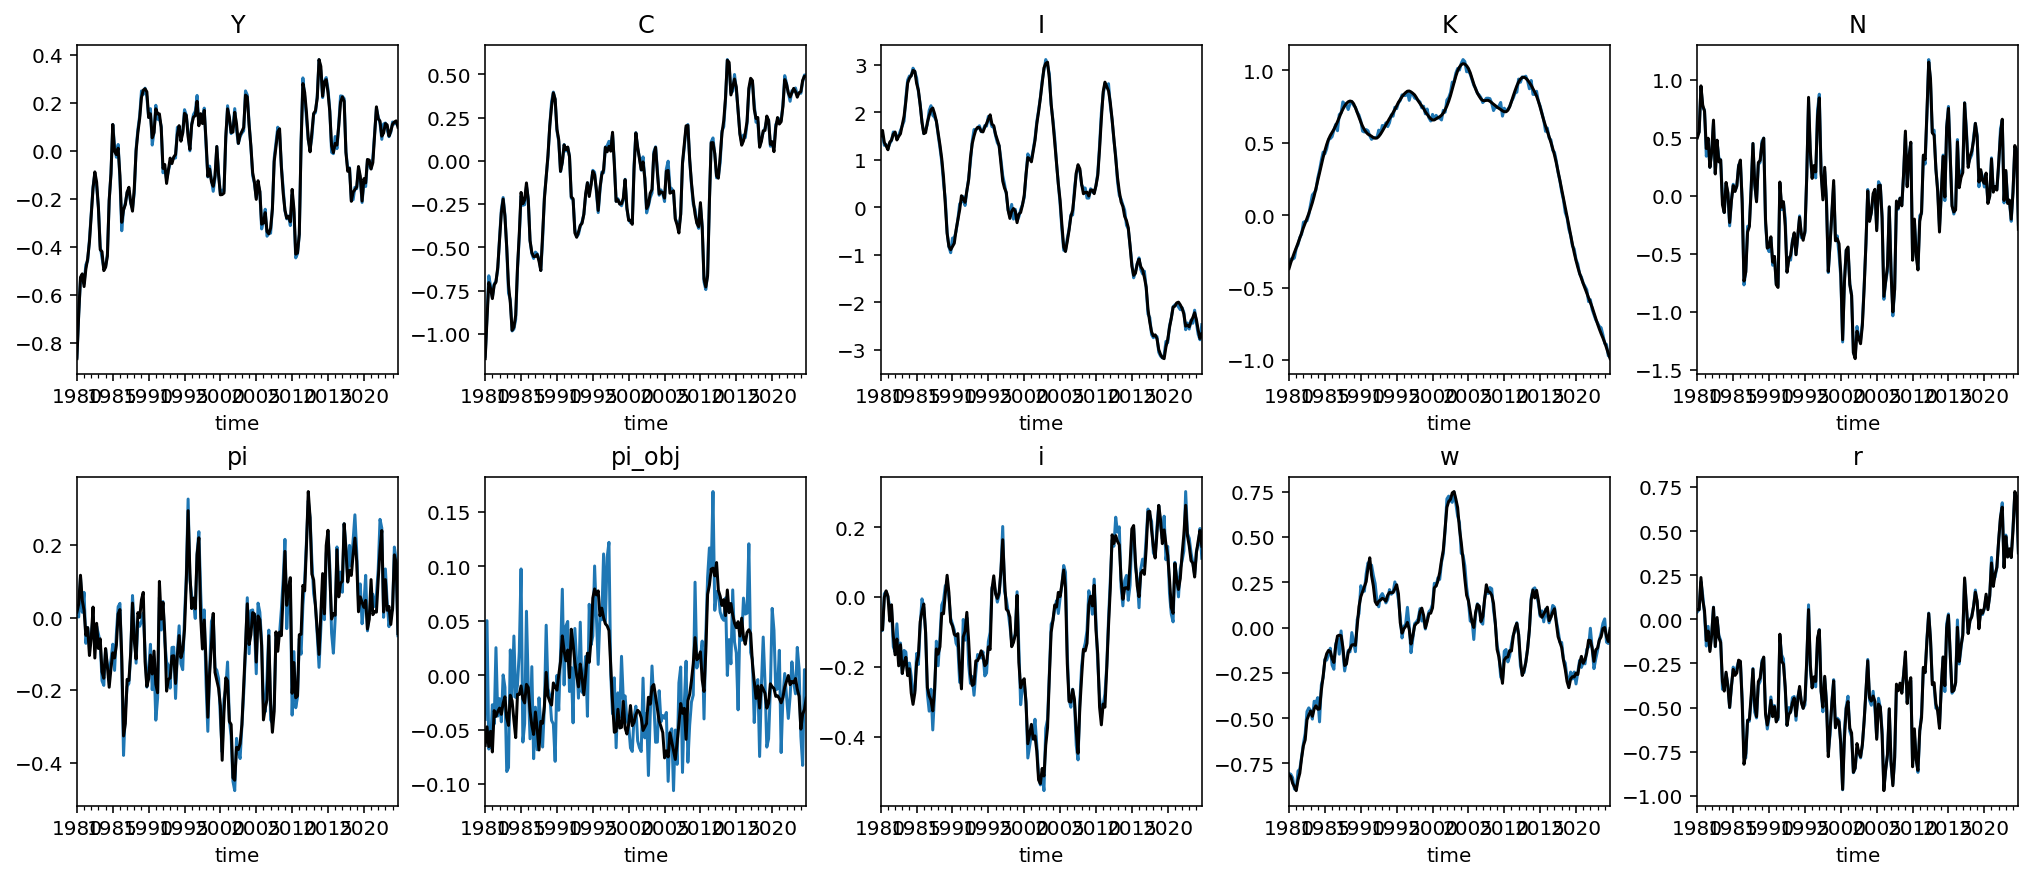

In [22]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)
    latent_data[col].plot(ax=axis, legend=False, color="k")

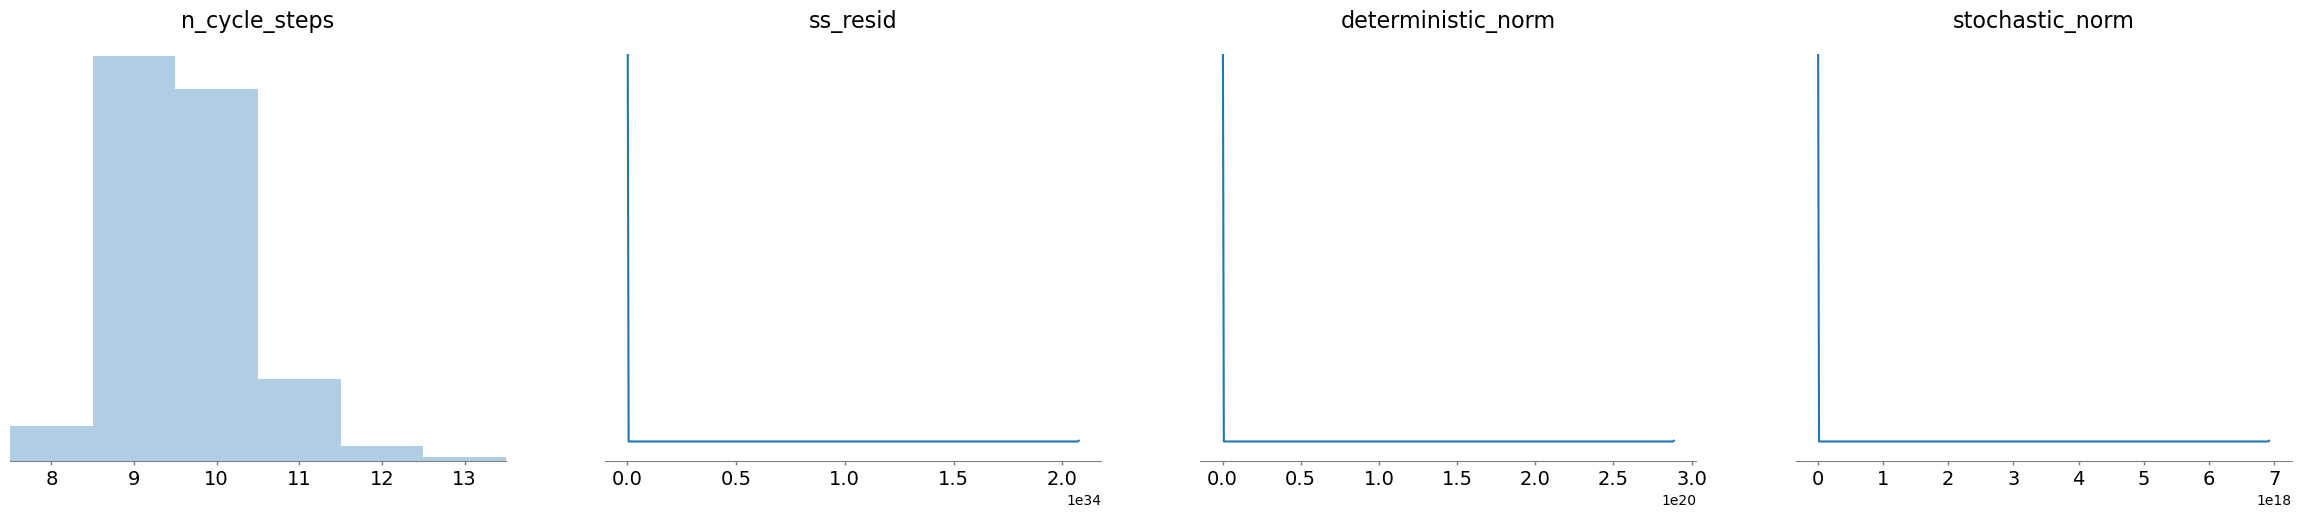

In [23]:
az.plot_posterior(
    prior_idata.prior,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
    hdi_prob="hide",
    point_estimate=None,
);

In [24]:
ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=None,
)
#                                  initial_points={k: v for k, v in ss_mod.param_dict.items() if k in pm_mod})

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [25]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-3,
        num_layers=3,
        nn_width=256,
        batch_size=512,
        #                                                 initial_skip=250,
        #                                                 num_diag_windows=11,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=2000,
    draws=1000,
    chains=6,
    target_accept=0.95,
    transform_adapt=True,
)

seedseed 9806060589855885602
seed 646784636883891281
seed 16612533259723188991
 15483833260686889582
seed 7661178577003011363
seed 5394023807304199302
Chain 5: Total available points: 11
seed 6095590761199088969
loss from diag: 6.19448594604452
Chain 3: Total available points: 11
seed 16859406896217356465
loss from diag: 6.127779778900037
Chain 0: Total available points: 11
seed 236002566618418261
loss from diag: 6.132746196356584
Chain 1: Total available points: 11
seed 8911418860681320437
loss from diag: 7.449086487581018
Chain 2: Total available points: 11
seed 8351607444216444833
loss from diag: 6.584251554673763
Chain 5: Total available points: 21
seed 8548868185704922897
loss from diag: 2.296091828829495
Chain 0: Total available points: 21
seed 1389697753469757553
loss from diag: 0.7104692523200529
Chain 4: Total available points: 11
seed 5877738328212925392
loss from diag: 6.425152171633399
Chain 0: Total available points: 31
seed 10371350757537486865
loss from diag: 4.293147722

Chain 3: Total available points: 251
Chain 4: Total available points: 301
Chain 3: New loss 4.295858119940205, old loss 5.010226637334186
Chain 4: New loss 4.072954388006304, old loss 4.314474275751126
Chain 0: Total available points: 301
Chain 2: Total available points: 301
Chain 0: New loss 4.118330607187914, old loss 4.696972791423529
Chain 2: New loss 3.4472169118318, old loss 4.9117232509740445
Chain 1: Total available points: 301
Chain 1: New loss 4.194914373420011, old loss 4.670946988395759
Chain 5: Total available points: 401
Extending flow...
3.93795459050406 [2.33973636 0.39893834 2.09409967 0.56056453 1.7812068  0.99828391
 0.86682252 2.14013253 0.76265783 0.53437646 2.86981474 3.93795459
 3.19873578 0.60547582 0.65838465 1.82338524 1.69691353 1.72359458
 0.89283276 1.10803368 0.49981355 0.92381516 0.8849575  1.04867537
 1.02029862 0.87977809 0.4206191  1.13961145 0.8513419  0.25773006
 0.38816721 0.99913188 0.29509584 0.87964187 0.26574701 0.44415889
 0.68791012 1.10231355

Chain 2: New loss 3.8356104818836996, old loss 4.4756725210475805
Chain 3: Total available points: 451
Chain 5: Total available points: 601
Extending flow...
0.8595183554025109 [0.60803657 0.6087339  0.51243912 0.62058826 0.50693169 0.55260442
 0.44195201 0.64408451 0.56262754 0.78452316 0.54026574 0.52620097
 0.58968952 0.55083199 0.52610678 0.54813561 0.52739519 0.57986909
 0.62559076 0.51563231 0.66070497 0.72951566 0.71061563 0.55212322
 0.57024037 0.52217726 0.49965926 0.62230777 0.53922197 0.62311347
 0.72758509 0.57097722 0.51587745 0.70764955 0.54045882 0.78103226
 0.63955566 0.68818653 0.63406735 0.85951836 0.6044109  0.63030517
 0.51873159 0.79232815 0.62434738 0.65095497 0.62395153 0.78471058
 0.68894714 0.53025958 0.58599676 0.5285309  0.53573873 0.66980507
 0.51195287 0.4931226  0.57386142 0.616981   0.80386742 0.59997042
 0.56296411 0.63654138 0.62997687 0.49080689 0.66365519 0.60319248
 0.51906062 0.58991103 0.75142346 0.61260316 0.53572837 0.51785579
 0.61660892 0.49685

1.1624951885579358 [0.51421539 0.33243897 0.76375268 0.22314848 0.47110814 0.38689456
 0.43814922 0.76739773 0.49791814 0.39909622 0.56774541 0.65263461
 0.5911549  0.38421717 0.57708812 0.67230117 0.63996639 0.67175533
 0.61532113 0.49543447 0.33421615 0.5566061  0.51523568 0.5131932
 0.52011242 0.43128938 0.27954193 0.53252174 0.5525677  0.23052955
 0.31400495 0.64801625 0.2258425  0.56941516 0.22436907 0.29835094
 0.38246888 0.67165327 0.4826146  0.6310144  0.32578734 0.40294657
 1.16249519 0.917288   0.40526859 0.28533987 0.75816762 0.60004291
 0.49632064 0.6677503  0.69797776 0.57084496 0.61026245 0.73851746
 0.78684838 0.43757313 0.57466277 0.76314061 0.61818927 0.68202927
 0.51732039 0.51496388 0.67084732 0.65454275 0.68853859 0.80291414
 0.60418277 0.71117638 0.66017087 0.78520887 0.53229336 0.65945219
 0.58279909 0.51901095 0.55402855 0.5428586  0.74252977 0.57013704
 0.68487972]
dct: False
Chain 5: New loss 3.8836611669907986, old loss 4.263423525687156
Chain 3: Total availab

Chain 0: Total available points: 951
Chain 3: New loss 3.81892799210902, old loss 4.054720338025852
Chain 0: New loss 3.7903491422316233, old loss 4.075019079817589
Chain 4: Total available points: 1001
Chain 4: New loss 3.502637110434443, old loss 3.749477943701961
Chain 1: Total available points: 901
Chain 1: New loss 3.9985296146496556, old loss 4.194779655129445
Chain 5: Total available points: 1051
Chain 5: New loss 3.704455163138532, old loss 3.80036622916054
Chain 2: Total available points: 1001
Chain 2: New loss 3.55853233016808, old loss 3.7499051144157063
Chain 4: Total available points: 1051
Chain 4: New loss 3.407895033519567, old loss 3.9004794061944352
Chain 0: Total available points: 1001
Chain 3: Total available points: 901
Chain 0: New loss 3.672686464253433, old loss 4.067849831040329
Chain 3: New loss 3.710209347223511, old loss 4.1717342716904025
Chain 1: Total available points: 951
Chain 1: New loss 3.5616258884742624, old loss 4.145183066280421
Chain 5: Total avai

Chain 2: New loss 3.1635157580010387, old loss 3.668071966657784
Chain 3: Total available points: 1501
Chain 3: New loss 3.4589354645521144, old loss 3.823211460927109
Chain 4: Total available points: 1701
Chain 1: Total available points: 1551
Chain 1: New loss 3.388927193232012, old loss 3.63697710562963
Chain 4: New loss 3.218628700363372, old loss 3.5689843341886758
Chain 5: Total available points: 1701
Chain 5: New loss 3.2977518814140923, old loss 3.5366429934206782
Chain 0: Total available points: 1651
Chain 2: Total available points: 1701
Chain 0: New loss 3.3136416209944786, old loss 3.6307334702249103
Chain 2: New loss 3.342130235555492, old loss 3.5461222037742366
Chain 3: Total available points: 1551
Chain 3: New loss 3.361807843601713, old loss 3.7473139644889017
Chain 4: Total available points: 1751
Chain 1: Total available points: 1601
Chain 4: New loss 3.4111825703601224, old loss 3.7310914506222743
Chain 0: Total available points: 1701
Chain 1: New loss 3.39299987759562

<Axes: >

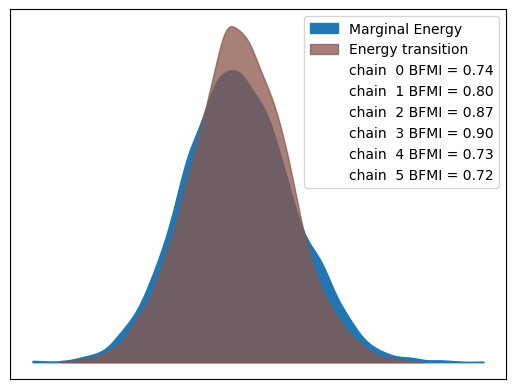

In [26]:
az.plot_energy(idata)

In [39]:
deep_params = [
    "alpha",
    "beta",
    "delta",
    "sigma",
    "theta",
    "chi",
    "gamma_I",
    "epsilon_p",
    "epsilon_w",
    "phi_H",
    "phi_p",
    "phi_w",
    "psi_z",
    "phi_pi",
    "phi_Y",
]
rho_params = [rv.name for rv in pm_mod.free_RVs if rv.name.startswith("rho")]
all_params = [
    rv.name
    for rv in pm_mod.free_RVs
    if "error" not in rv.name and "state_chol" not in rv.name
]
error_params = [rv.name for rv in pm_mod.free_RVs if rv.name.startswith("error")]
state_chol = ["state_chol"]

corner(
    idata,
    var_names=deep_params,
    divergences=True,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
);

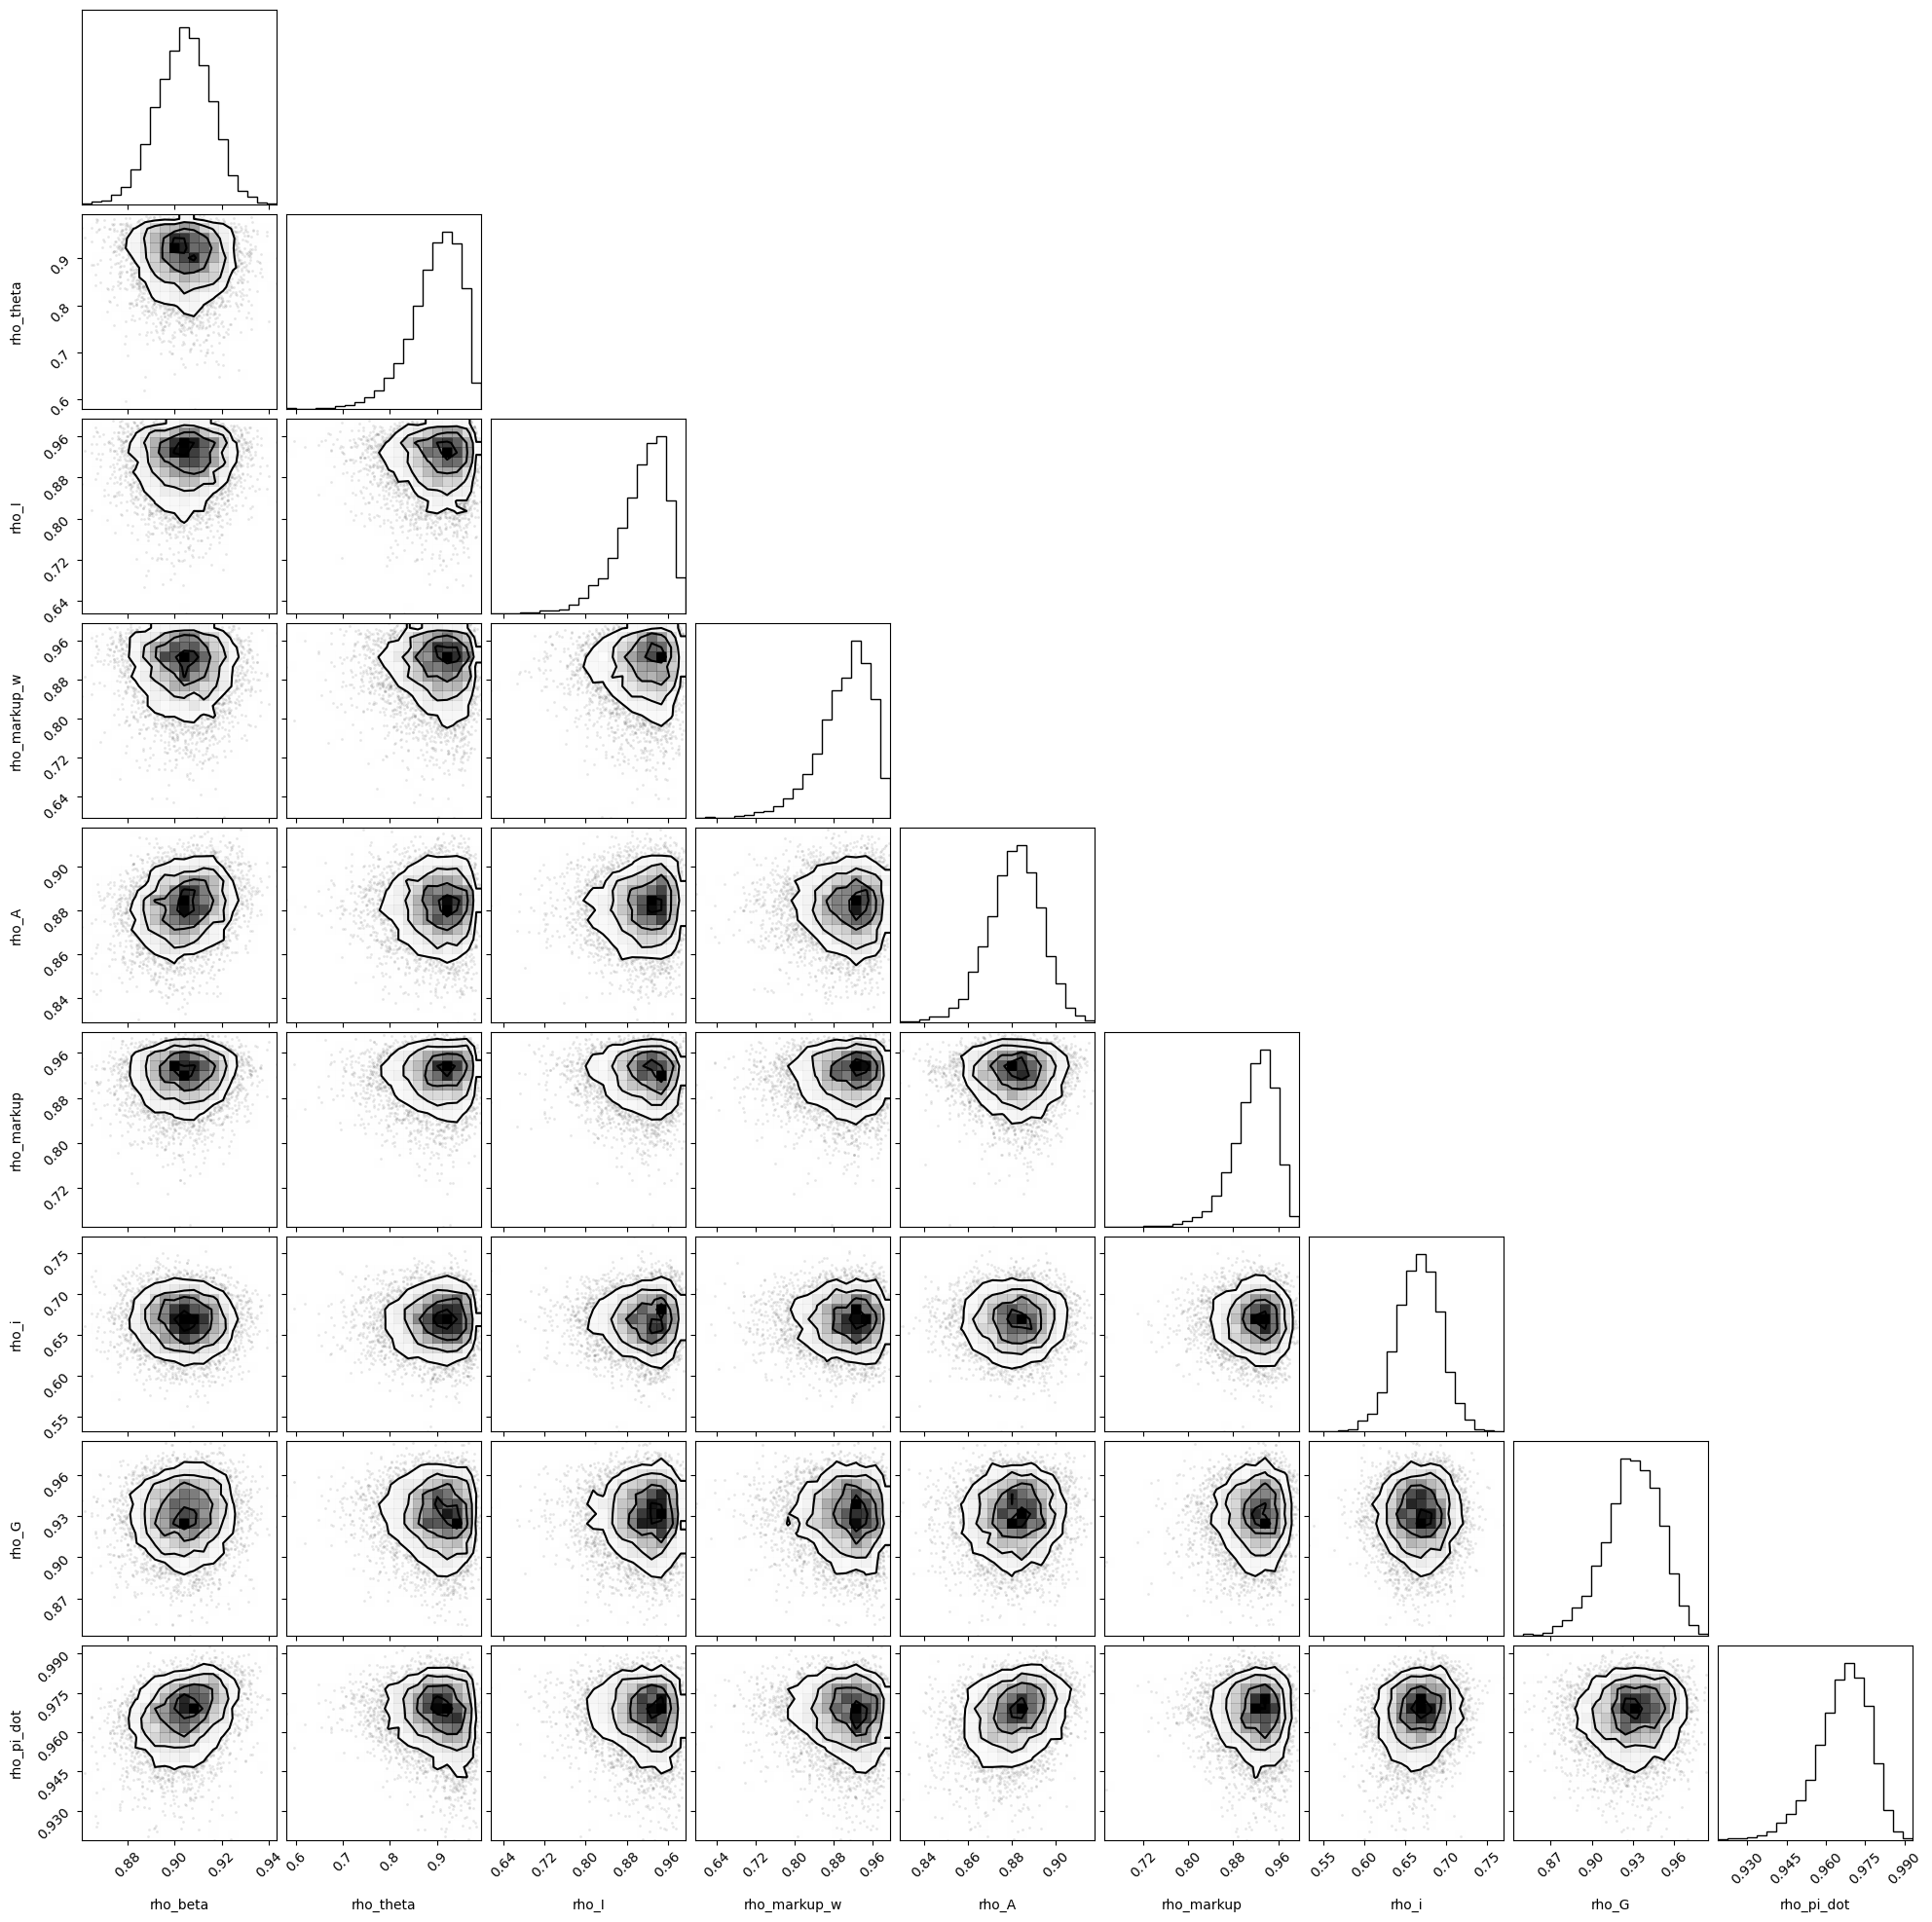

In [40]:
corner(
    idata,
    var_names=rho_params,
    divergences=True,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
);

In [66]:
def plot_posterior_with_prior(
    idata, var_names, prior_dict, true_values=None, n_cols=5, figsize=None
):
    if true_values is None:
        ref_val = None
    else:
        ref_val = np.r_[
            *[true_values[name].values.ravel() for name in var_names]
        ].tolist()

    if figsize is None:
        figsize = (14, 9)

    fig = plt.figure(figsize=figsize, dpi=144)
    gs, locs = gp.prepare_gridspec_figure(
        n_cols=n_cols, n_plots=len(var_names), figure=fig
    )
    [fig.add_subplot(gs[loc]) for loc in locs]

    axes = az.plot_posterior(
        idata, var_names=var_names, ref_val=ref_val, ax=np.array(fig.axes)
    )
    for axis in axes.ravel():
        var_name, *coords = axis.get_title().split("\n")

        if var_name in prior_dict:
            prior_dict[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")
    fig.tight_layout()
    plt.show()

In [67]:
plot_posterior_with_prior(
    idata, deep_params, all_priors, true_values=true_params, n_cols=4, figsize=(16, 12)
)

In [68]:
plot_posterior_with_prior(
    idata, rho_params, all_priors, true_values=true_params, n_cols=4, figsize=(16, 12)
)

In [69]:
plot_posterior_with_prior(
    idata, error_params, all_priors, true_values=true_params, n_cols=4, figsize=(16, 12)
)

In [70]:
from itertools import product

n_shocks = ss_mod.k_posdef

fig, ax = plt.subplots(
    n_shocks,
    n_shocks,
    figsize=(8, 8),
    dpi=144,
    subplot_kw={"aspect": "equal"},
    sharex=True,
    sharey=True,
)

true_corr = true_params.state_chol_corr.values
mu = idata.posterior.state_chol_corr.mean(dim=["chain", "draw"])
hdi = az.hdi(idata.posterior.state_chol_corr).state_chol_corr
ax[0, 0].set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

for i, j in product(range(n_shocks), range(n_shocks)):
    axis = ax[i, j]
    if i <= j:
        axis.set_visible(False)
        continue
    y_var = mod.shocks[i].base_name
    x_var = mod.shocks[j].base_name
    axis.scatter(mu.values[i, j], 0)
    axis.scatter(true_corr[i, j], 0, marker="*", color="tab:red")

    axis.hlines(0, *hdi.values[i, j])
    axis.axvline(0, ls="--", c="k", lw=0.5)

    axis.set_ylabel(y_var if j == 0 else "", fontsize=6)
    axis.set_xlabel(x_var if i == (n_shocks - 1) else "", fontsize=6)
    axis.set_yticklabels([])

plt.show()

In [71]:
az.plot_posterior(
    idata,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
);

In [72]:
cond_post = ss_mod.sample_conditional_posterior(idata)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0xB97266EA0>), RNG(<Generator(PCG64) at 0xB97266DC0>), RNG(<Generator(PCG64) at 0xB97266CE0>), RNG(<Generator(PCG64) at 0xB97266C00>), RNG(<Generator(PCG64) at 0xB97266B20>), RNG(<Generator(PCG64) at 0xB98970C80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

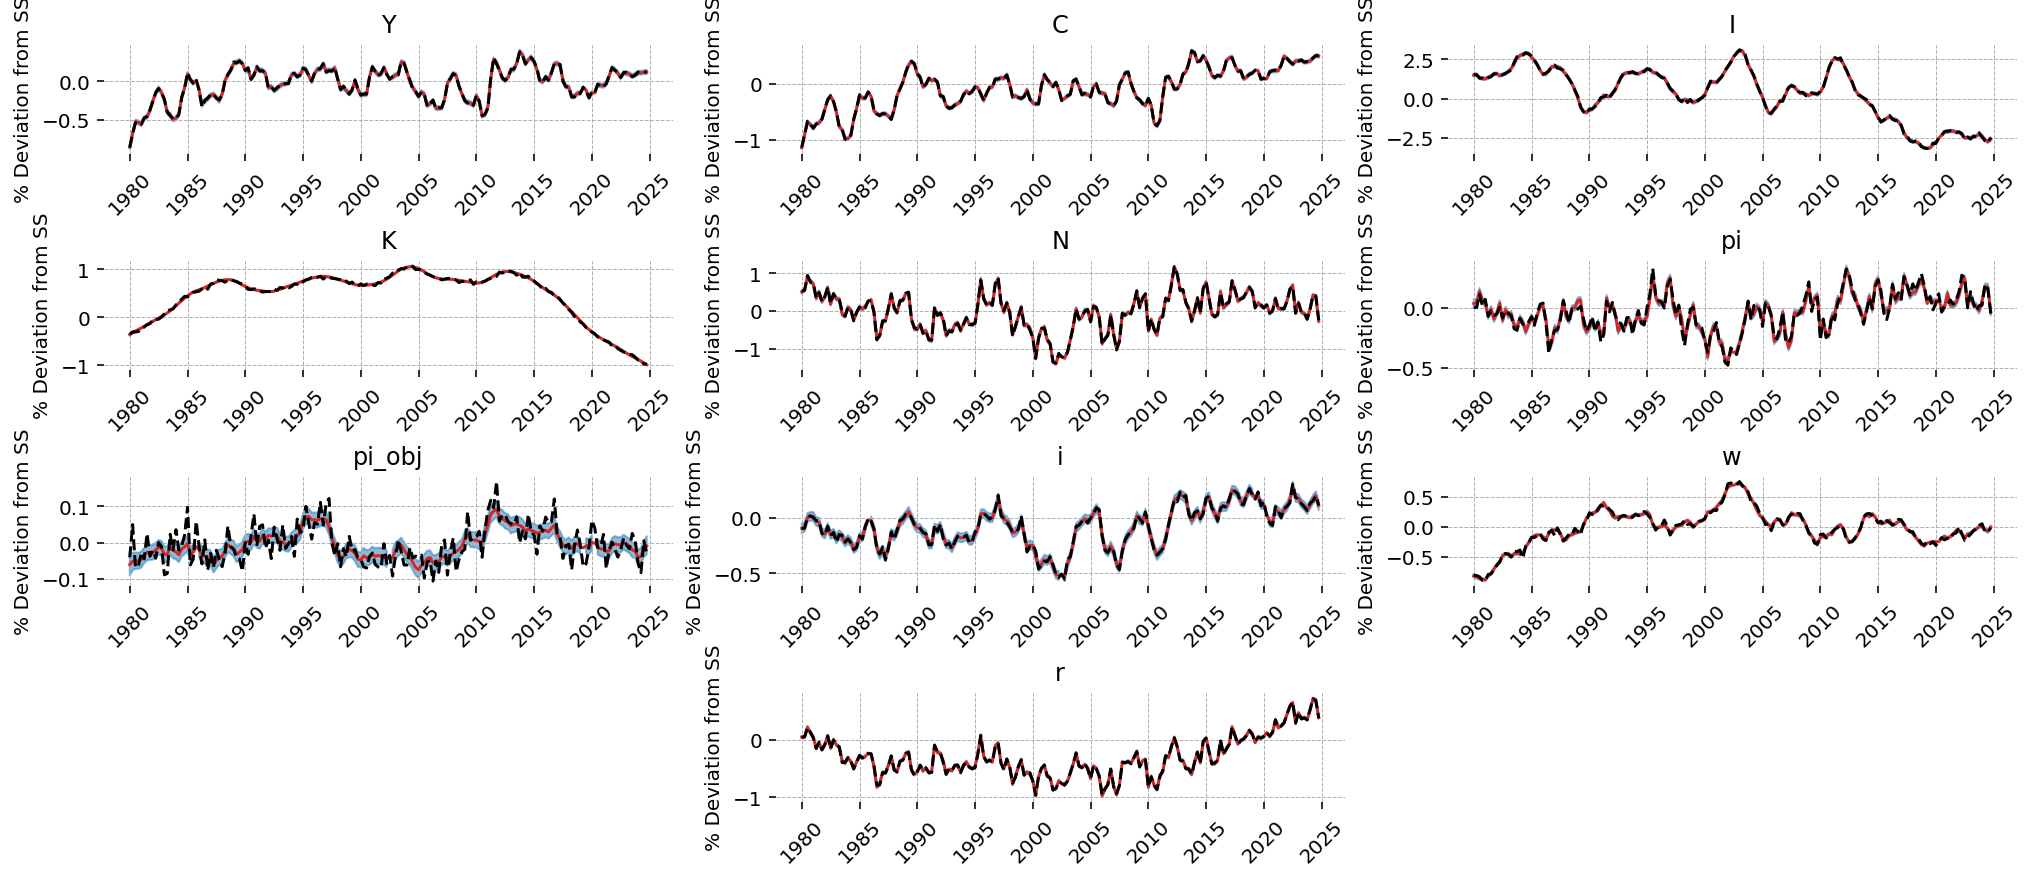

In [73]:
gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=3,
    vars_to_plot=ss_mod.observed_states,
);

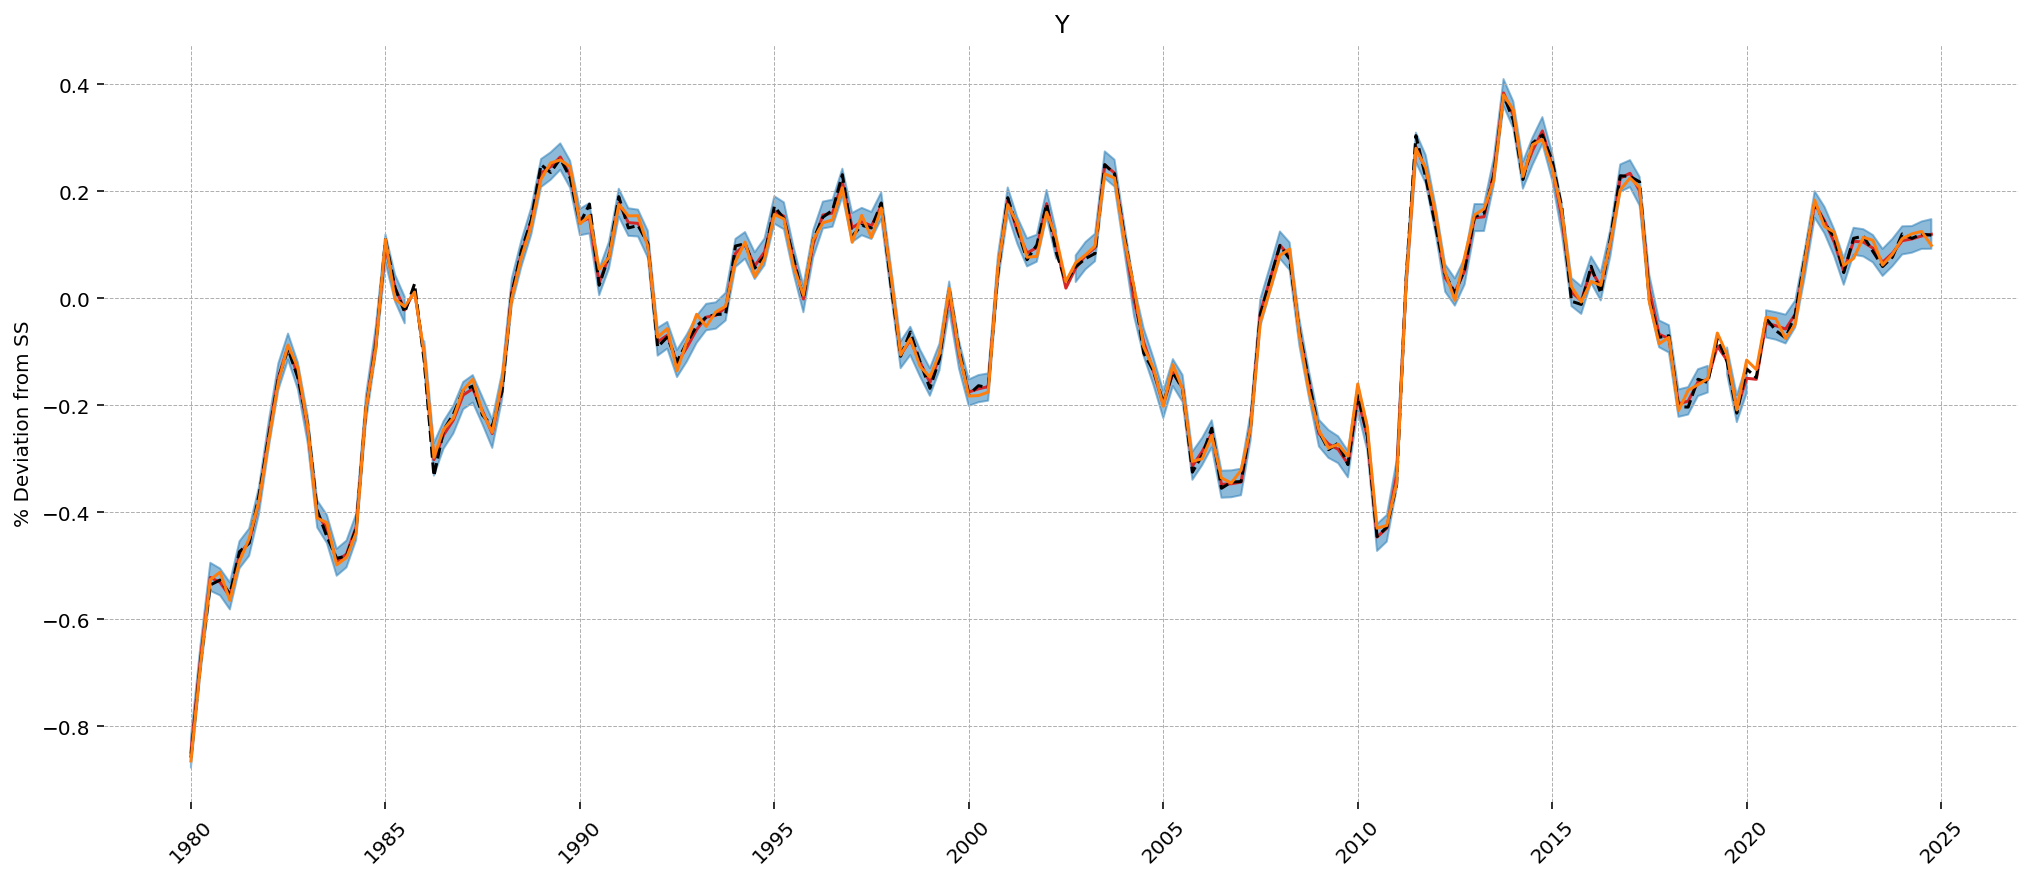

In [74]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["Y"]
)
ax = fig.axes[0]
ax.plot(latent_data.index, latent_data["Y"], color="tab:orange")

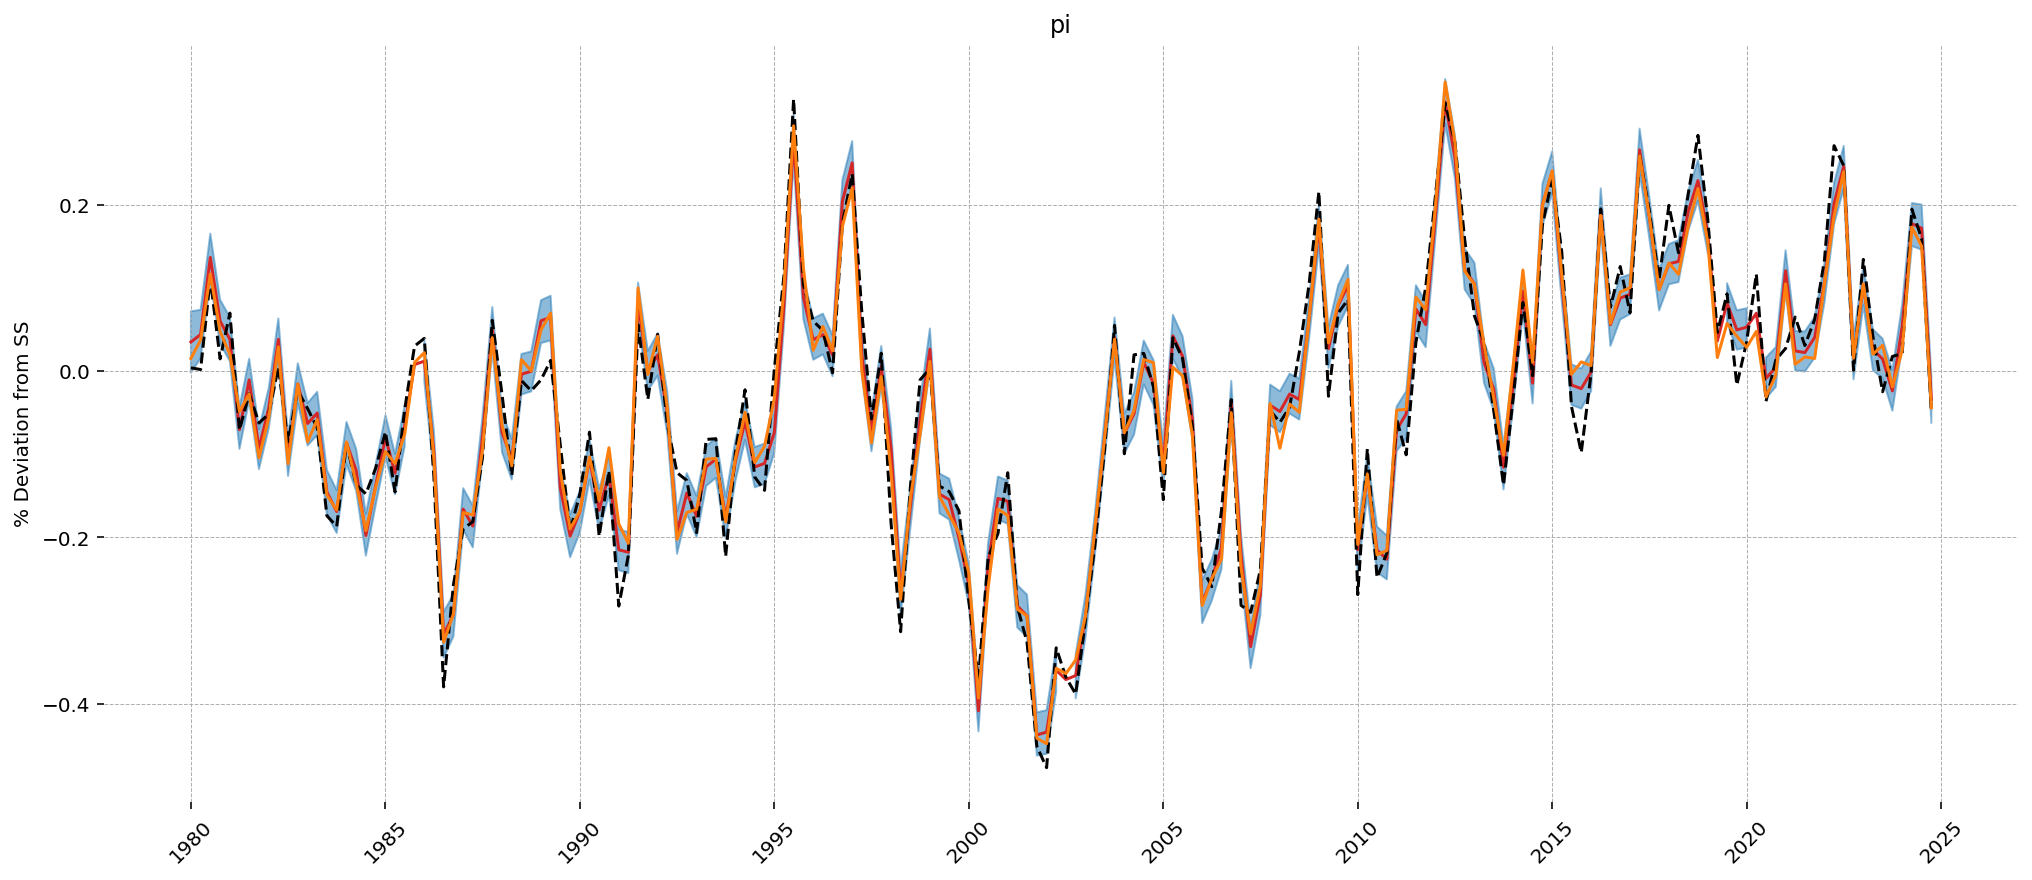

In [75]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["pi"]
)
ax = fig.axes[0]
ax.plot(latent_data.index, latent_data["pi"], color="tab:orange")

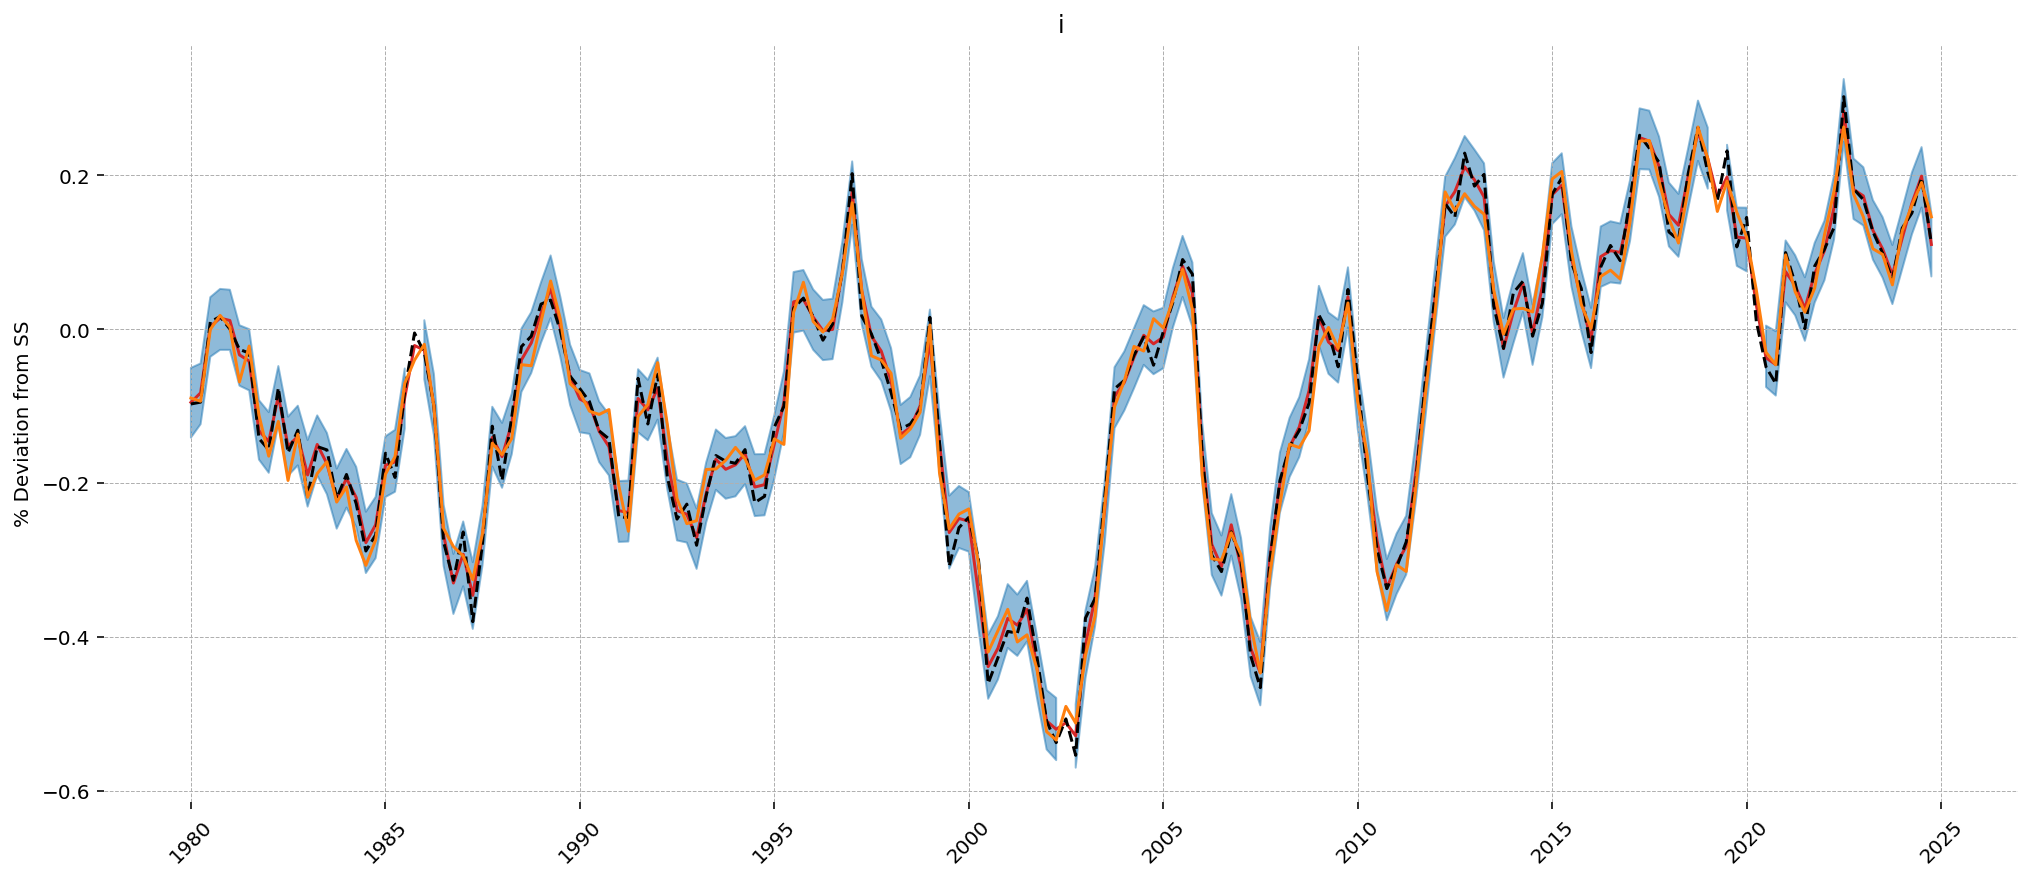

In [76]:
fig = gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["i"]
)
ax = fig.axes[0]
ax.plot(latent_data.index, latent_data["i"], color="tab:orange")

In [99]:
fig = gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=2,
    vars_to_plot=["epsilon_w", "epsilon_p", "A", "beta", "theta", "shock_I", "z"],
)
for axis in fig.axes:
    var = axis.get_title()
    axis.plot(latent_data.index, latent_data[var], color="tab:orange")